<a href="https://colab.research.google.com/github/dksifoua/Neural-Machine-Translation/blob/master/5%20-%20SeqToSeq%20Model%20with%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Oct  3 02:38:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [ ]:
!pip install tqdm --upgrade >> /dev/null 2>&1
!pip install torchtext --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download de >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [ ]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import Multi30k

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Load data

In [ ]:
%%time
DE = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='de', batch_first=True)
EN = Field(init_token='<sos>', eos_token='<eos>', lower=True, tokenize='spacy', tokenizer_language='en', batch_first=True)
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),  fields=(DE, EN))
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 5.48MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.45MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.36MB/s]


train set size: 29,000
valid set size: 1,014
test set size: 1,000
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
CPU times: user 6.34 s, sys: 198 ms, total: 6.54 s
Wall time: 7.23 s


## Build vocabularies

In [ ]:
%%time
MIN_COUNT = 2
DE.build_vocab(train_data, min_freq=MIN_COUNT, specials=['<unk>', '<pad>'])
EN.build_vocab(train_data, min_freq=MIN_COUNT, specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of DE vocabulary: {len(DE.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of DE vocabulary: 7,854
Length of EN vocabulary: 5,893
CPU times: user 294 ms, sys: 1.99 ms, total: 296 ms
Wall time: 295 ms


## Modeling

***Scaled Dot Product Layer***

In [ ]:
class ScaledDotProductAttnLayer(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttnLayer, self).__init__()
    
    def forward(self, query, key, value, mask):
        """
        :param Tensor[batch_size, ..., q_len, dk] query
        :param Tensor[batch_size, ..., k_len, dk] key
        :param Tensor[batch_size, ..., v_len, dv] value
        :param Tensor[batch_size, ..., k_len] mask
        :return Tensor[batch_size, ..., q_len, dv] output
        :return Tensor[batch_size, ..., q_len, key_len] attn_weights
        """
        scores = torch.matmul(query, key.transpose(-1, -2)) # [batch_size, ..., q_len, k_len]
        scores = scores / torch.sqrt(torch.FloatTensor([query.size(-1)]).to(query.device)) # Scaling
        if mask is not None: # Apply mask
            # mask [batch_size, 1, k_len] or [batch_size, seq_len, k_len]
            # Unsqueeze dim=1 => [batch_size, 1, 1, k_len] or [batch_size, 1, k_len, k_len]
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, 1e-9)
        attn_weights = F.softmax(scores, dim=-1) # [batch_size, ..., q_len, k_len]
        output = torch.matmul(attn_weights, value) # [batch_size, ..., q_len, dv]
        return output, attn_weights

***Multi-Head Attention Layer***

In [ ]:
class MultiHeadAttnLayer(nn.Module):

    def __init__(self, d_model, n_heads):
        super(MultiHeadAttnLayer, self).__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.dk = d_model // n_heads
        self.dv = d_model // n_heads
        self.fc_query = nn.Linear(d_model, d_model)
        self.fc_key = nn.Linear(d_model, d_model)
        self.fc_value = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        self.scaled_dot_product_attention = ScaledDotProductAttnLayer()

    def forward(self, query, key, value, mask):
        """
        :param Tensor[batch_size, q_len, d_model] query
        :param Tensor[batch_size, k_len, d_model] key
        :param Tensor[batch_size, v_len, d_model] value
        :param Tensor[batch_size, ..., q_len] mask
        :return Tensor[batch_size, q_len, d_model] outputs
        :return Tensor[batch_size, n_heads, q_len, key_len] attn_weights
        """
        Q = self.fc_query(query) # [batch_size, query_len, d_model]
        K = self.fc_key(key) # [batch_size, key_len, d_model]
        V = self.fc_value(value) # [batch_size, value_len, d_model]

        Q = Q.view(Q.size(0), -1, self.n_heads, self.dk).permute(0, 2, 1, 3) # [batch_size, n_heads, q_len, dk]
        K = K.view(K.size(0), -1, self.n_heads, self.dk).permute(0, 2, 1, 3) # [batch_size, n_heads, k_len, dk]
        V = V.view(V.size(0), -1, self.n_heads, self.dv).permute(0, 2, 1, 3) # [batch_size, n_heads, v_len, dv]

        if mask is not None:
            if len(mask.size()) == 2:
                mask = mask.unsqueeze(1) # [batch_size, 1, q_len]
            # else already unsqueezed [batch_size, q_len, q_len]

        outputs, attn_weights = self.scaled_dot_product_attention(query=Q, key=K, value=V, mask=mask)
        # outputs: [batch_size, n_heads, q_len, dv]
        # attn_weights: [batch_size, n_heads, q_len, key_len]

        outputs = torch.reshape(outputs, (outputs.size(0), outputs.size(2), -1)) # [batch_size, q_len, d_model]
        outputs = self.fc(outputs) # [batch_size, q_len, d_model]

        return outputs, attn_weights

***Position-Wise Feed-Forward Layer***

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):

    def __init__(self, d_model, hidden_size):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.d_model = d_model
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(d_model, hidden_size)
        self.fc2 = nn.Linear(hidden_size, d_model)

    def forward(self, x):
        """
        :param Tensor[batch_size, seq_len, d_model] x
        :return Tensor[batch_size, seq_len, d_model] x
        """
        x = F.relu(self.fc1(x)) # [batch_size, seq_len, hidden_size]
        x = self.fc2(x) # [batch_size, seq_len, d_model]
        return x

***Positional Encoding Layer***

In [ ]:
class PositionalEncodingLayer(nn.Module):

    def __init__(self, max_length, d_model):
        super(PositionalEncodingLayer, self).__init__()
        self.max_length = max_length
        self.d_model = d_model

    def get_angles(self, positions, indexes):
        d_model_tensor = torch.FloatTensor([[self.d_model]]).to(positions.device)
        angle_rates = torch.pow(10000, (2 * (indexes // 2)) / d_model_tensor)
        return positions / angle_rates

    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, seq_len] input_sequences
        :return Tensor[batch_size, seq_len, d_model] position_encoding
        """
        positions = torch.arange(input_sequences.size(1)).unsqueeze(1).to(input_sequences.device) # [seq_len, 1]
        indexes = torch.arange(self.d_model).unsqueeze(0).to(input_sequences.device) # [1, d_model]
        angles = self.get_angles(positions, indexes) # [seq_len, d_model]
        angles[:, 0::2] = torch.sin(angles[:, 0::2]) # apply sin to even indices in the tensor; 2i
        angles[:, 1::2] = torch.cos(angles[:, 1::2]) # apply cos to odd indices in the tensor; 2i
        position_encoding = angles.unsqueeze(0).repeat(input_sequences.size(0), 1, 1) # [batch_size, seq_len, d_model]
        return position_encoding

(64, 50, 512)


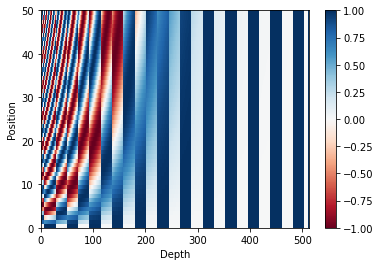

In [ ]:
l = PositionalEncodingLayer(50, 512)
pos_encoding = l(torch.randint(100, size=(64, 50))).numpy()
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

***Encoder Block Layer***

In [ ]:
class EncoderBlockLayer(nn.Module):

    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(EncoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.multi_head_attention_layer = MultiHeadAttnLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, inputs, mask):
        """
        :param Tensor[batch_size, seq_len, d_model] inputs
        :param Tensor[batch_size, seq_len] mask
        :return Tensor[batch_size, seq_len, d_model] outputs
        """
        outputs, _ = self.multi_head_attention_layer(query=inputs, key=inputs, value=inputs, mask=mask)
        x = self.multi_head_attention_layer_norm(self.dropout(outputs) + inputs)
        outputs = self.position_wise_feed_forward_layer(x)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + x)
        return outputs

***Encoder Layer***

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, vocab_size, max_length, d_model, n_heads, hidden_size, n_layers, dropout):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(max_length=max_length, d_model=d_model)
        self.encoder_blocks = nn.ModuleList([EncoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size,
                                                               dropout=dropout) for _ in range(n_layers)])
    
    def forward(self, input_sequences, mask):
        """
        :param Tensor[batch_size, seq_len] input_sequences
        :param Tensor[batch_size, seq_len] mask
        :return Tensor[batch_size, seq_len, d_model] out
        """
        token_embedded = self.embedding(input_sequences) # [batch_size, seq_len, d_model]
        position_encoded = self.position_encoding(input_sequences) # [batch_size, seq_len, d_model]
        out = self.dropout(token_embedded) + position_encoded # [batch_size, seq_len, d_model]
        for encoder_block in self.encoder_blocks:
            out = encoder_block(inputs=out, mask=mask) # [batch_size, seq_len, d_model]
        return out

***Decoder Block Layer***

In [ ]:
class DecoderBlockLayer(nn.Module):

    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(DecoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.multi_head_attention_layer_1 = MultiHeadAttnLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm_1 = nn.LayerNorm(d_model)
        self.multi_head_attention_layer_2 = MultiHeadAttnLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm_2 = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, dest_inputs, enc_src, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len, d_model] dest_inputs
        :param Tensor[batch_size, src_len, d_model] enc_src
        :param Tensor[batch_size, dest_len, dest_len] dest_mask
        :param Tensor[batch_size, src_len] src_mask
        :return Tensor[batch_size, dest_len, d_model] outputs
        :return Tensor[batch_size, n_heads, dest_len, src_len] attn_weights
        """
        outputs, _ = self.multi_head_attention_layer_1(query=dest_inputs, key=dest_inputs, value=dest_inputs, mask=dest_mask)
        x = self.multi_head_attention_layer_norm_1(self.dropout(outputs) + dest_inputs) # [batch_size, dest_len, d_model]
        outputs, attn_weights = self.multi_head_attention_layer_2(query=x, key=enc_src, value=enc_src, mask=src_mask)
        x = self.multi_head_attention_layer_norm_2(self.dropout(outputs) + x) # [batch_size, dest_len, d_model]
        outputs = self.position_wise_feed_forward_layer(x)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + x) # [batch_size, dest_len, d_model]
        return outputs, attn_weights

***Decoder Layer***

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, vocab_size, max_length, d_model, n_heads, hidden_size, n_layers, dropout):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(max_length=max_length, d_model=d_model)
        self.decoder_blocks = nn.ModuleList([DecoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size,
                                                               dropout=dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, dest_sequences, enc_src, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len] dest_sequences
        :param Tensor[batch_size, src_len, d_model] enc_src
        :param Tensor[batch_size, dest_len, dest_len] dest_mask
        :param Tensor[batch_size, src_len] src_mask
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attn_weights
        """
        token_embedded = self.embedding(dest_sequences) # [batch_size, dest_len, d_model]
        position_encoded = self.position_encoding(dest_sequences) # [batch_size, dest_len, d_model]
        out = self.dropout(token_embedded) + position_encoded # [batch_size, dest_len, d_model]
        for decoder_block in self.decoder_blocks:
            out, attn_weights = decoder_block(dest_inputs=out, enc_src=enc_src, dest_mask=dest_mask, src_mask=src_mask)
        logits = self.fc(out) # [batch_size, dest_len, vocab_size]
        return logits, attn_weights

***Transformer Model***

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder, decoder, src_pad_index, dest_pad_index):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_index = src_pad_index
        self.dest_pad_index = dest_pad_index

    def make_src_mask(self, src_sequences):
        """
        Mask <pad> tokens.
        :param Tensor[batch_size, src_len] src_sequences
        :return Tensor[batch_size, src_len]
        """
        return src_sequences != self.src_pad_index # [batch_size, src_len]
    
    def make_dest_mask(self, dest_sequences):
        """
        Mask <pad> tokens and futur tokens as well.
        :param Tensor[batch_size, src_len] src_sequences
        :return tensor[batch_size, dest_len, dest_len]
        """
        mask = dest_sequences != self.dest_pad_index # [batch_size, dest_len]
        sub_mask = torch.tril(torch.ones(dest_sequences.size(1), dest_sequences.size(1), device=dest_sequences.device)).bool() # [dest_len, dest_len]
        return mask.unsqueeze(1) & sub_mask # [batch_size, dest_len, dest_len]
    
    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, dest_len] dest_sequences
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attn_weights
        """
        src_mask, dest_mask = self.make_src_mask(src_sequences), self.make_dest_mask(dest_sequences)
        enc_src = self.encoder(input_sequences=src_sequences, mask=src_mask) # [batch_size, src_len, d_model]
        logits, attn_weights = self.decoder(dest_sequences=dest_sequences, enc_src=enc_src, dest_mask=dest_mask, src_mask=src_mask)
        # logits [batch_size, dest_len, vocab_size]
        # attn_weights [batch_size, n_heads, dest_len, src_len]
        return logits, attn_weights

***Training routines***

In [ ]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [ ]:
def accuracy(outputs, target_sequences, k=5):
    """
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    # print([*map(lambda token: EN.vocab.itos[token], outputs.argmax(dim=-1)[0].tolist())])
    # print([*map(lambda token: EN.vocab.itos[token], target_sequences[0].tolist())])
    # print("="*100)
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())

In [ ]:
class Trainer:

    def __init__(self, model, optimizer, criterion, train_iterator, valid_iterator):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

    def adjust_lr(self, shrink_factor=0.9, verbose=True):
        if verbose:
            print("\nDecaying learning rate.")
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * shrink_factor
        if verbose:
            print("The new learning rate is %f\n" % (self.optimizer.param_groups[0]['lr'],))
    
    def train_step(self, epoch, grad_clip):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(self.train_iterator), total=len(self.train_iterator))
        for i, batch in progress_bar:
            src, trg = batch.src, batch.trg
            self.optimizer.zero_grad()
            logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
            loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            acc_tracker.update(accuracy(logits, trg[:, 1:]))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(self.valid_iterator), total=len(self.valid_iterator))
            for i, batch in progress_bar:
                src, trg = batch.src, batch.trg
                logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
                loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
                loss_tracker.update(loss.item())
                acc_tracker.update(accuracy(logits, trg[:, 1:]))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, n_epochs, grad_clip):
        history = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}
        best_loss, last_improv = np.inf, 0
        for epoch in range(n_epochs):
            if last_improv == 4:
                print('Training Finished - The model has stopped improving since last 4 epochs')
                break
            if last_improv > 0:
                self.adjust_lr()
            loss, ppl, acc = self.train_step(epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(epoch)
            
            if best_loss > val_loss:
                best_loss, last_improv = val_loss, 0
                torch.save(self.model.state_dict(), 'transformer.pth')
            else:
                last_improv += 1
                print(f'\nLast improvement since epoch {epoch - last_improv + 1}')
            
            history['acc'].append(acc)
            history['ppl'].append(ppl)
            history['loss'].append(loss)
            history['val_acc'].append(val_acc)
            history['val_ppl'].append(val_ppl)
            history['val_loss'].append(val_loss)
        return history

***Train the model***

In [ ]:
D_MODEL = 256
N_LAYERS = 2
N_HEADS = 8
HIDDEN_SIZE = 512
MAX_LEN = 50
DROPOUT = 0.1
BATCH_SIZE = 64
LR = 1e-3
N_EPOCHS = 10
GRAD_CLIP = 1.0

In [ ]:
encoder = EncoderLayer(vocab_size=len(DE.vocab), max_length=MAX_LEN, d_model=D_MODEL, n_heads=N_HEADS, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, dropout=DROPOUT)
decoder = DecoderLayer(vocab_size=len(EN.vocab), max_length=MAX_LEN, d_model=D_MODEL, n_heads=N_HEADS, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS, dropout=DROPOUT)
transformer = Transformer(encoder=encoder, decoder=decoder, src_pad_index=DE.vocab.stoi[DE.pad_token], dest_pad_index=EN.vocab.stoi[EN.pad_token]).to(DEVICE)
optimizer = optim.Adam(params=transformer.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {sum(p.numel() for p in transformer.parameters() if p.requires_grad):,}')
print(transformer)
train_iterator, valid_iterator, test_iterator =  BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=DEVICE)
trainer = Trainer(model=transformer, optimizer=optimizer, criterion=criterion, train_iterator=train_iterator, valid_iterator=valid_iterator)

Number of parameters of the model: 6,351,621
Transformer(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (embedding): Embedding(7854, 256)
    (position_encoding): PositionalEncodingLayer()
    (encoder_blocks): ModuleList(
      (0): EncoderBlockLayer(
        (dropout): Dropout(p=0.1, inplace=False)
        (multi_head_attention_layer): MultiHeadAttnLayer(
          (fc_query): Linear(in_features=256, out_features=256, bias=True)
          (fc_key): Linear(in_features=256, out_features=256, bias=True)
          (fc_value): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (scaled_dot_product_attention): ScaledDotProductAttnLayer()
        )
        (multi_head_attention_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=Tru

In [ ]:
history = trainer.train(n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 3.174 -     ppl: 23.910 -     acc: 6.767%: 100%|██████████| 454/454 [00:12<00:00, 36.05it/s]
Epoch: 01 - val_loss: 3.209 - val_ppl: 24.748 - val_acc: 10.788%: 100%|██████████| 16/16 [00:00<00:00, 100.65it/s]
Epoch: 02 -     loss: 1.715 -     ppl: 5.556 -     acc: 8.723%: 100%|██████████| 454/454 [00:12<00:00, 36.14it/s]
Epoch: 02 - val_loss: 3.082 - val_ppl: 21.793 - val_acc: 11.507%: 100%|██████████| 16/16 [00:00<00:00, 100.24it/s]
Epoch: 03 -     loss: 1.205 -     ppl: 3.335 -     acc: 9.344%: 100%|██████████| 454/454 [00:12<00:00, 35.90it/s]
Epoch: 03 - val_loss: 2.936 - val_ppl: 18.844 - val_acc: 11.848%: 100%|██████████| 16/16 [00:00<00:00, 96.37it/s]
Epoch: 04 -     loss: 0.930 -     ppl: 2.536 -     acc: 9.732%: 100%|██████████| 454/454 [00:12<00:00, 35.88it/s]
Epoch: 04 - val_loss: 3.226 - val_ppl: 25.170 - val_acc: 11.778%: 100%|██████████| 16/16 [00:00<00:00, 98.04it/s] 
Epoch: 05 -     loss: 0.933 -     ppl: 2.543 -     acc: 8.966%:   1%|          | 3/4


Last improvement since epoch 3

Decaying learning rate.
The new learning rate is 0.000900



Epoch: 05 -     loss: 0.764 -     ppl: 2.147 -     acc: 9.903%: 100%|██████████| 454/454 [00:12<00:00, 35.93it/s]
Epoch: 05 - val_loss: 3.194 - val_ppl: 24.374 - val_acc: 11.668%: 100%|██████████| 16/16 [00:00<00:00, 100.81it/s]
Epoch: 06 -     loss: 0.641 -     ppl: 1.897 -     acc: 9.704%:   1%|          | 3/454 [00:00<00:18, 24.13it/s]


Last improvement since epoch 3

Decaying learning rate.
The new learning rate is 0.000810



Epoch: 06 -     loss: 0.657 -     ppl: 1.928 -     acc: 10.015%: 100%|██████████| 454/454 [00:12<00:00, 35.77it/s]
Epoch: 06 - val_loss: 3.084 - val_ppl: 21.853 - val_acc: 12.033%: 100%|██████████| 16/16 [00:00<00:00, 94.65it/s]
Epoch: 07 -     loss: 0.789 -     ppl: 2.201 -     acc: 8.989%:   1%|          | 3/454 [00:00<00:18, 23.98it/s]


Last improvement since epoch 3

Decaying learning rate.
The new learning rate is 0.000729



Epoch: 07 -     loss: 0.588 -     ppl: 1.800 -     acc: 10.095%: 100%|██████████| 454/454 [00:12<00:00, 35.97it/s]
Epoch: 07 - val_loss: 3.154 - val_ppl: 23.436 - val_acc: 12.160%: 100%|██████████| 16/16 [00:00<00:00, 103.10it/s]


Last improvement since epoch 3
Training Finished - The model has stopped improving since last 4 epochs


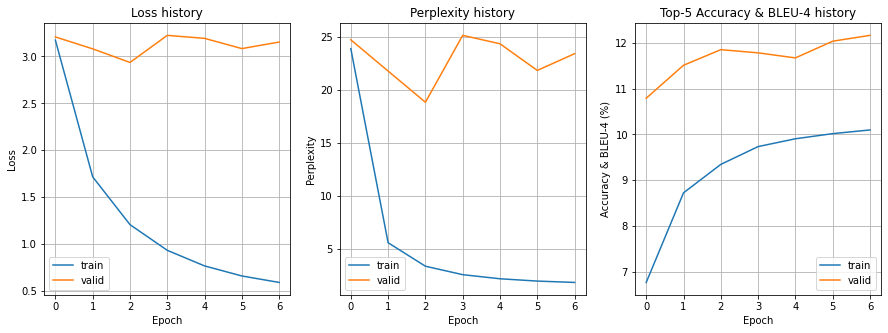

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

In [ ]:
transformer.load_state_dict(torch.load('transformer.pth'))
transformer.to(DEVICE)

Transformer(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.1, inplace=False)
    (embedding): Embedding(7854, 256)
    (position_encoding): PositionalEncodingLayer()
    (encoder_blocks): ModuleList(
      (0): EncoderBlockLayer(
        (dropout): Dropout(p=0.1, inplace=False)
        (multi_head_attention_layer): MultiHeadAttnLayer(
          (fc_query): Linear(in_features=256, out_features=256, bias=True)
          (fc_key): Linear(in_features=256, out_features=256, bias=True)
          (fc_value): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (scaled_dot_product_attention): ScaledDotProductAttnLayer()
        )
        (multi_head_attention_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, o

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_dest_mask(trg_tensor)
        # print(trg_mask)
        # if i == 5: break
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
example_idx = 10

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, DE, EN, transformer, DEVICE)

print(f'predicted trg = {translation}')

src = ['eine', 'ballettklasse', 'mit', 'fünf', 'mädchen', ',', 'die', 'nacheinander', 'springen', '.']
trg = ['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence', '.']
predicted trg = ['church', 'church', 'their', 'their', 'their', 'their', 'hands', 'their', 'hands', '.', '<eos>']


In [ ]:
3

3